# Aggregate the snow reanalyses HMASR to about 10km (only seasonal snow)

- HMASR: [High Mountain Asia UCLA Daily Snow Reanalysis, Version 1](https://nsidc.org/data/HMA_SR_D)

conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '../utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [2]:
# For parallelisation
from dask.distributed import Client
from dask import delayed
from dask import compute
client = Client(n_workers=4, threads_per_worker=3, memory_limit='6GB')
# client = Client()
client

Client Scheduler: tcp://127.0.0.1:42457 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 24.00 GB


In [6]:
client.close()

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


## Create folders

In [3]:
# Create folders
WY_list = ['WY'+str(year)+'_'+str(i).zfill(2) for i, year in enumerate(range(1999, 2017))]
path_out = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_10km/'

!mkdir {path_out}
for WY in WY_list:
    print(WY)
    !mkdir {path_out}{WY}

mkdir: impossible de créer le répertoire « /mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_10km/ »: Le fichier existe
WY1999_00
WY2000_01
WY2001_02
WY2002_03
WY2003_04
WY2004_05
WY2005_06
WY2006_07
WY2007_08
WY2008_09
WY2009_10
WY2010_11
WY2011_12
WY2012_13
WY2013_14
WY2014_15
WY2015_16
WY2016_17


- FORCING_POST -> PPT_Post
- SD_POST -> SD_Post
- SWE_SCA_POST -> SWE_Post, SCA_Post

## Aggregate data in parallel
There are different option with `dask`. I didn't succeed to make it work with `xr.open_mfdataset` as there are too many files and there is a memory crash. So I finally used the `delayed` option from dask, in order to parallelize a loop.

Here are the different ressources:
- http://xarray.pydata.org/en/stable/user-guide/dask.html
- https://ncar.github.io/xdev/posts/writing-multiple-netcdf-files-in-parallel-with-xarray-and-dask/ (I use this on for writting in parallel)
- https://tutorial.dask.org/01_dask.delayed.html (I used this example for delayed)

The delayed from dask is a bit tricky and we can't use all functions.

The goal here is just to coarsen grids. Then I will put all the files together in a single file for efficiency.

In [27]:
path

'/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/WY2011_12/'

In [7]:
WY_list[2]

'WY2001_02'

In [24]:
list_files[486]

'HMA_SR_D_v01_N42_0E85_0_agg_16_WY2001_02_SWE_SCA_POST.nc'

In [ ]:
HMA_SR_D_v01_N42_0E85_0_agg_16_WY2001_02_SWE_SCA_POST

In [5]:
# for WY in WY_list[3:]:
for WY in ['WY2004_05']:
    print(WY)
    path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/'+WY+'/'
    path_out = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_10km/'+WY+'/'
    
    for ds_name in ['SWE_SCA_POST']:
        print(ds_name)
        list_files = [f for f in listdir(path) if ds_name in f]

        ds_10km = []
        for file in list_files:
#         for file in list_files[486:]:
            print(file)
            ds = xr.open_dataset(path+file).load()
            mask = xr.open_dataset(path+file.replace(ds_name, 'MASK')).load()
            ds_10km = ds.isel(Stats=0).where(mask.Non_seasonal_snow_mask == 0).coarsen(Latitude=25, Longitude=25).mean()
            ds_10km.to_netcdf(path_out+file)

WY2004_05
SWE_SCA_POST
HMA_SR_D_v01_N39_0E92_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N35_0E80_0_agg_16_WY2004_05_SWE_SCA_POST.nc


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HMA_SR_D_v01_N28_0E92_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N37_0E100_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N28_0E67_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N35_0E101_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N35_0E90_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N38_0E74_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N29_0E91_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N38_0E94_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N28_0E87_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N39_0E97_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N35_0E104_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N34_0E66_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N34_0E76_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N39_0E72_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N28_0E97_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N29_0E81_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N28_0E82_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N39_0E77_0_agg_

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HMA_SR_D_v01_N33_0E95_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E102_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N30_0E88_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N36_0E90_0_agg_16_WY2004_05_SWE_SCA_POST.nc


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HMA_SR_D_v01_N29_0E89_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N36_0E70_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N40_0E70_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E66_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N29_0E69_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N30_0E80_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N30_0E70_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E76_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N29_0E99_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N36_0E95_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N32_0E101_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N30_0E90_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N38_0E101_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N36_0E85_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N35_0E98_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N37_0E93_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E103_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N35_0E88_0_agg_

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HMA_SR_D_v01_N27_0E90_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N32_0E104_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N41_0E76_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N36_0E103_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N41_0E83_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N40_0E75_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N30_0E85_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N43_0E88_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N37_0E73_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N34_0E102_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N35_0E68_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N38_0E89_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E78_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N38_0E79_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E68_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N38_0E69_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N43_0E78_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E88_0_agg_

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HMA_SR_D_v01_N38_0E73_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N29_0E101_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N37_0E89_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N36_0E92_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N34_0E96_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N29_0E96_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N34_0E84_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N44_0E84_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N35_0E72_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N34_0E86_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N42_0E84_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N27_0E98_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N37_0E99_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E79_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N44_0E94_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N28_0E90_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N34_0E74_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N32_0E76_0_agg_16

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HMA_SR_D_v01_N35_0E67_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N43_0E87_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E86_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N32_0E89_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E65_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N41_0E74_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N43_0E77_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N40_0E72_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E87_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E84_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N35_0E92_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N34_0E87_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N42_0E81_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N32_0E91_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E94_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N27_0E100_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N37_0E102_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E97_0_agg_1

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HMA_SR_D_v01_N32_0E82_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N32_0E92_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E101_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N34_0E72_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N42_0E71_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N34_0E91_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N30_0E69_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E89_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E91_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N40_0E69_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E64_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N39_0E93_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N43_0E89_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N30_0E101_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E87_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E74_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E100_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N41_0E81_0_agg_

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HMA_SR_D_v01_N31_0E81_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E99_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N40_0E71_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N30_0E84_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N38_0E96_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N42_0E69_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N41_0E87_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N38_0E86_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N32_0E69_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E67_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N30_0E92_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N41_0E72_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N38_0E75_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N28_0E93_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N39_0E95_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N29_0E90_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N32_0E79_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N38_0E90_0_agg_16_

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HMA_SR_D_v01_N34_0E92_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N35_0E74_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N44_0E82_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N35_0E91_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E98_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E88_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N41_0E88_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N32_0E85_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E71_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E73_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N42_0E87_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E100_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E63_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E82_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E69_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N38_0E68_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N34_0E101_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N32_0E95_0_agg_1

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HMA_SR_D_v01_N38_0E78_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N40_0E74_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E102_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N43_0E79_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N29_0E87_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N34_0E103_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E80_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E92_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N29_0E85_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E79_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N41_0E82_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N40_0E76_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N29_0E78_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N42_0E70_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N39_0E94_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N29_0E97_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N36_0E102_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N38_0E72_0_agg_

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HMA_SR_D_v01_N39_0E79_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N36_0E100_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N30_0E89_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N29_0E68_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N30_0E103_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N39_0E69_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N29_0E95_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N30_0E99_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N32_0E62_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N38_0E70_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N38_0E87_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E84_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N43_0E84_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N28_0E94_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E65_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E94_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N28_0E96_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N32_0E78_0_agg_1

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HMA_SR_D_v01_N27_0E84_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N37_0E72_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N37_0E97_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N32_0E98_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N41_0E85_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N34_0E104_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N36_0E94_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N36_0E73_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N32_0E88_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N35_0E96_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N38_0E102_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N35_0E66_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E85_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N39_0E91_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N40_0E73_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N28_0E99_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N29_0E100_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E95_0_agg_

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HMA_SR_D_v01_N34_0E70_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E96_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N39_0E71_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N32_0E80_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E66_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E86_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N37_0E88_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N35_0E73_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N38_0E77_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N38_0E67_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N34_0E85_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N43_0E86_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N28_0E84_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N34_0E95_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N42_0E80_0_agg_16_WY2004_05_SWE_SCA_POST.nc


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HMA_SR_D_v01_N29_0E82_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N35_0E63_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N40_0E66_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N37_0E98_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N27_0E66_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N29_0E92_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N34_0E68_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N41_0E70_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N36_0E83_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N31_0E70_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N30_0E86_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N29_0E67_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N33_0E76_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N38_0E92_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N28_0E81_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N43_0E93_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N36_0E93_0_agg_16_WY2004_05_SWE_SCA_POST.nc
HMA_SR_D_v01_N32_0E65_0_agg_16_

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


HMA_SR_D_v01_N39_0E89_0_agg_16_WY2004_05_SWE_SCA_POST.nc


In [8]:
WY_list[13]

'WY2012_13'

In [10]:
from os import listdir

WY_list = ['WY'+str(year)+'_'+str(i).zfill(2) for i, year in enumerate(range(1999, 2017))]
ds_name_list = ['SD_POST', 'SWE_SCA_POST'] # Forcing post not used and not reliable
# ds_name_list = ['SWE_SCA_POST']

# for WY in WY_list:
for WY in WY_list[13:]:
    print(WY)
    path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/'+WY+'/'
    path_out = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_10km/'+WY+'/'
    
    for ds_name in ds_name_list:
        print(ds_name)
        list_files = [f for f in listdir(path) if ds_name in f]
        
        ds_10km = []
        for file in list_files:
            ds = delayed(xr.open_dataset)(path+file)
            mask = delayed(xr.open_dataset)(path+file.replace(ds_name, 'MASK'))
            
            # Select only the mean (Stats=0)
            ds_10km.append(ds.isel(Stats=0).where(mask.Non_seasonal_snow_mask == 0).coarsen(Latitude=25, Longitude=25).mean())
                
        ds_10km = compute(ds_10km)
        xr.save_mfdataset(ds_10km[0], [path_out+file for file in list_files])

WY2012_13
SD_POST
SWE_SCA_POST
WY2013_14
SD_POST
SWE_SCA_POST
WY2014_15
SD_POST
SWE_SCA_POST
WY2015_16
SD_POST
SWE_SCA_POST
WY2016_17
SD_POST
SWE_SCA_POST


## Combine files to a single file
Add also dates and rename/reorganize dimensions

In [4]:
WY_list = ['WY'+str(year)+'_'+str(i).zfill(2) for i, year in enumerate(range(1999, 2017))]
WY_list[1]

'WY2000_01'

In [5]:
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_10km/'
WY_list = ['WY'+str(year)+'_'+str(i).zfill(2) for i, year in enumerate(range(1999, 2017))]
ds_name_list = ['SD_POST', 'SWE_SCA_POST']
# ds_name_list = ['SWE_SCA_POST']

# for WY in WY_list:
for WY in WY_list[1:]:
    print(WY)
    for ds_name in ds_name_list:
        print(ds_name)
        ds = xr.open_mfdataset(path+WY+'/*'+ds_name+'.nc', parallel=True)
        ds = ds.assign_coords(Day=pd.date_range(start=WY[2:6]+'-10-01', periods=ds.Day.size, freq='D'))
        ds = ds.rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")
        
        # Round lat/lon (to avoid numerical error at the end... ex 25.5000012)
        # Adapt the precision
#         ds['lat'] = np.round(ds.lat, 1) ; ds['lon'] = np.round(ds.lon, 1)
        
        ds.to_netcdf(path+'HMA_SR_D_v01_10km_'+WY+'_'+ds_name+'.nc')
        
        #########
        ### + check size of SWE_SCA otherwise open and save back

WY2000_01
SD_POST
SWE_SCA_POST


RuntimeError: NetCDF: HDF error

## Test to open

In [9]:
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_10km/'
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_10km_WY*_SD_POST.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 54, lon: 132, time: 6575)
Coordinates:
  * lat      (lat) float64 27.17 27.5 27.83 28.17 ... 43.83 44.17 44.5 44.83
  * lon      (lon) float64 61.17 61.5 61.83 62.17 ... 103.8 104.2 104.5 104.8
  * time     (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2017-09-30
Data variables:
    SD_Post  (time, lat, lon) float32 dask.array<chunksize=(366, 54, 132), meta=np.ndarray>

In [10]:
da = ds.SD_Post
da

<xarray.DataArray 'SD_Post' (time: 6575, lat: 54, lon: 132)>
dask.array<concatenate, shape=(6575, 54, 132), dtype=float32, chunksize=(366, 54, 132), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 27.17 27.5 27.83 28.17 ... 43.83 44.17 44.5 44.83
  * lon      (lon) float64 61.17 61.5 61.83 62.17 ... 103.8 104.2 104.5 104.8
  * time     (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2017-09-30

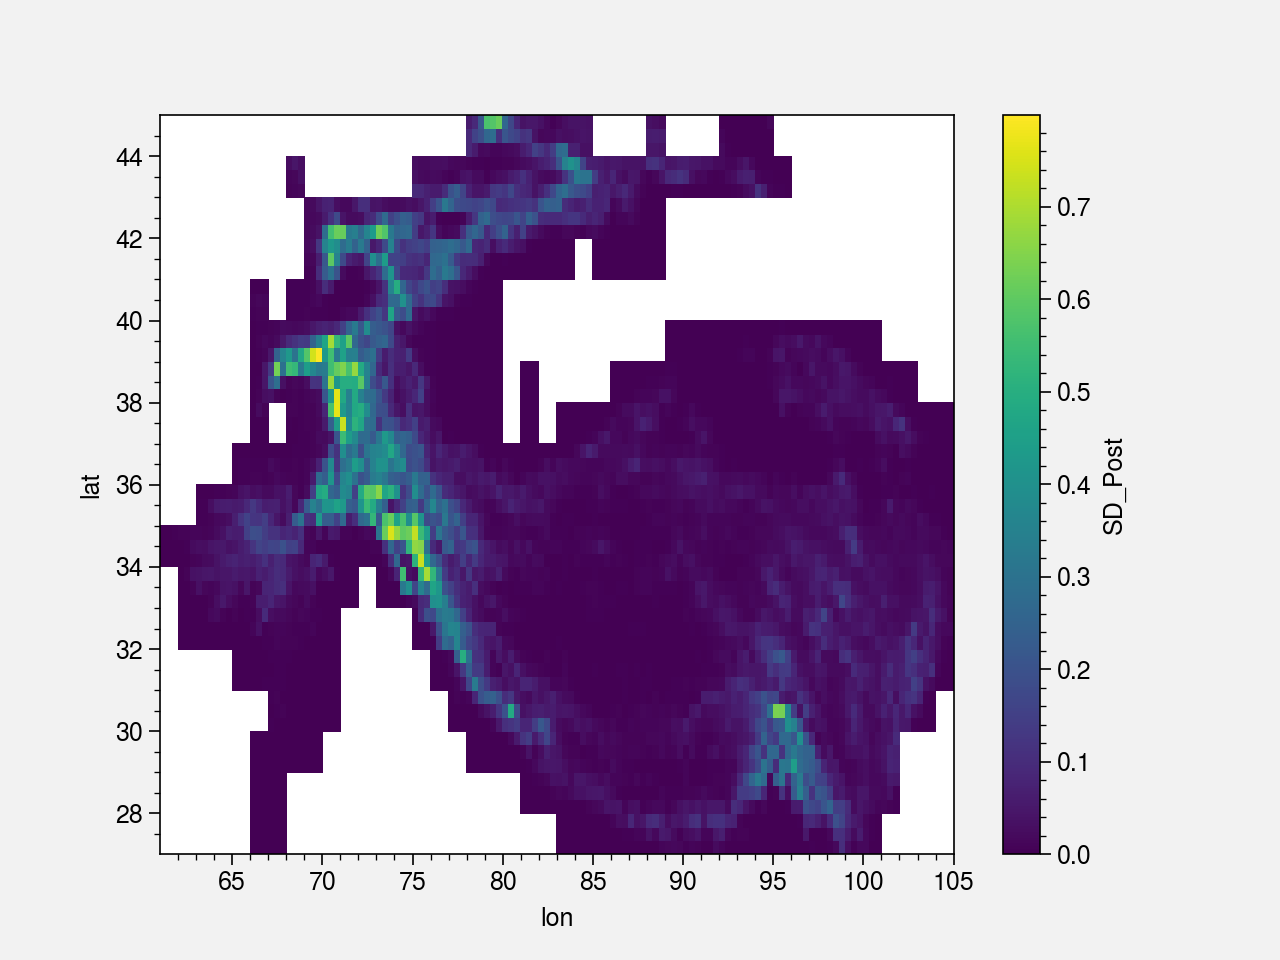

In [11]:
da.mean('time').plot()

In [12]:
da.load()

<xarray.DataArray 'SD_Post' (time: 6575, lat: 54, lon: 132)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 27.17 27.5 27.83 28.17 ... 43.83 44.17 44.5 44.83
  * lon      (lon) float64 61.17 61.5 61.83 62.17 ... 103.8 104.2 104.5 104.8
  * time     (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2017-09-30

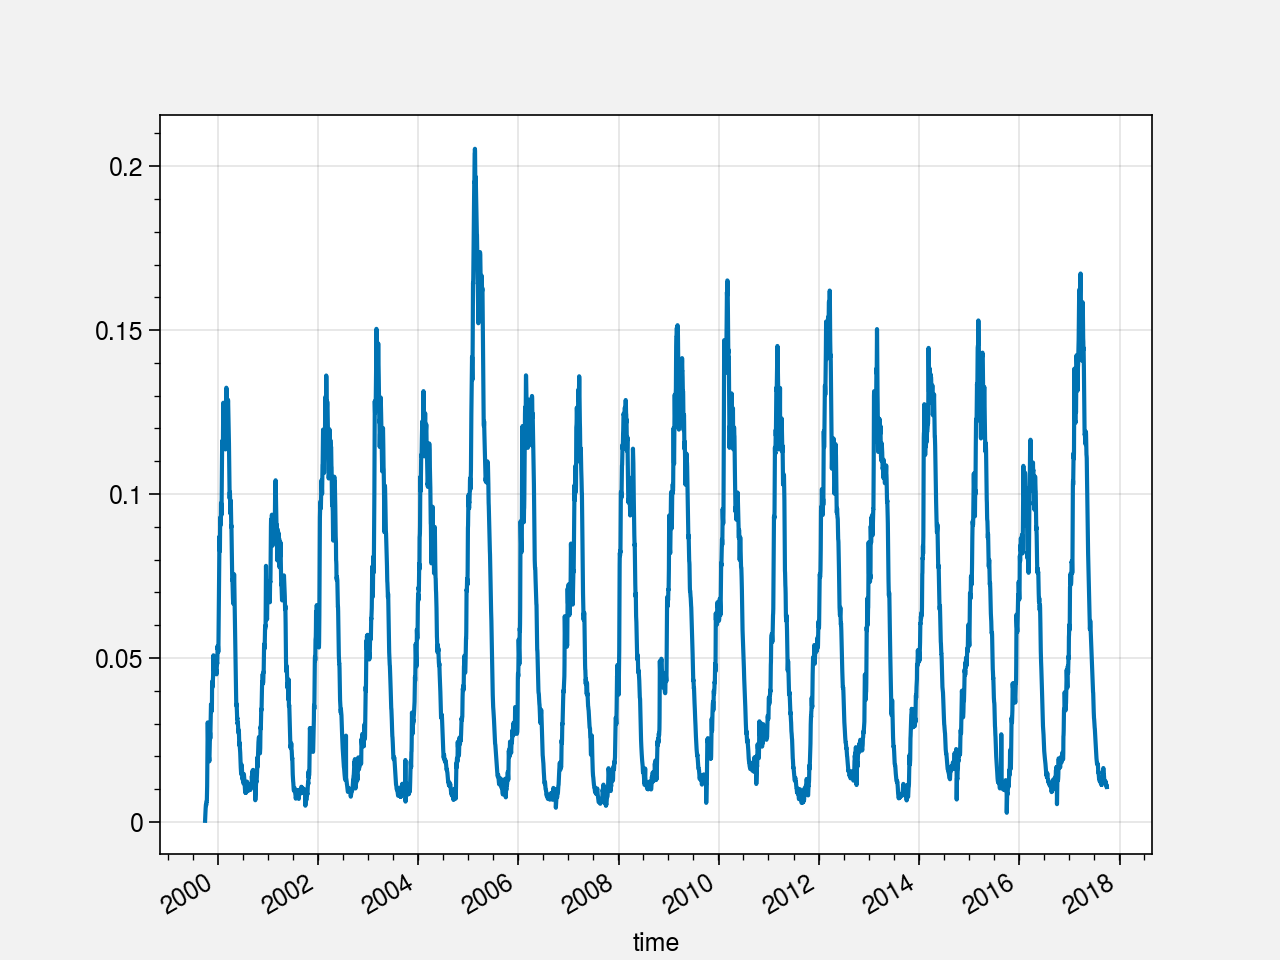

In [13]:
u.spatial_average(da).plot()

In [14]:
%%time
path='/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/WY1999_00/'
mask = xr.open_mfdataset(path+'HMA_SR_D_v01_*_agg_16_WY1999_00_MASK.nc', parallel=True).Non_seasonal_snow_mask
permanent_snow_count = mask.coarsen(Latitude=25, Longitude=25).sum().load()
permanent_snow_count = permanent_snow_count.rename({'Longitude': 'lon', 'Latitude': 'lat'}).transpose("lat", "lon")
mask_psnow = (permanent_snow_count/(25*25)*100)

CPU times: user 15.7 s, sys: 1.09 s, total: 16.8 s
Wall time: 29.3 s


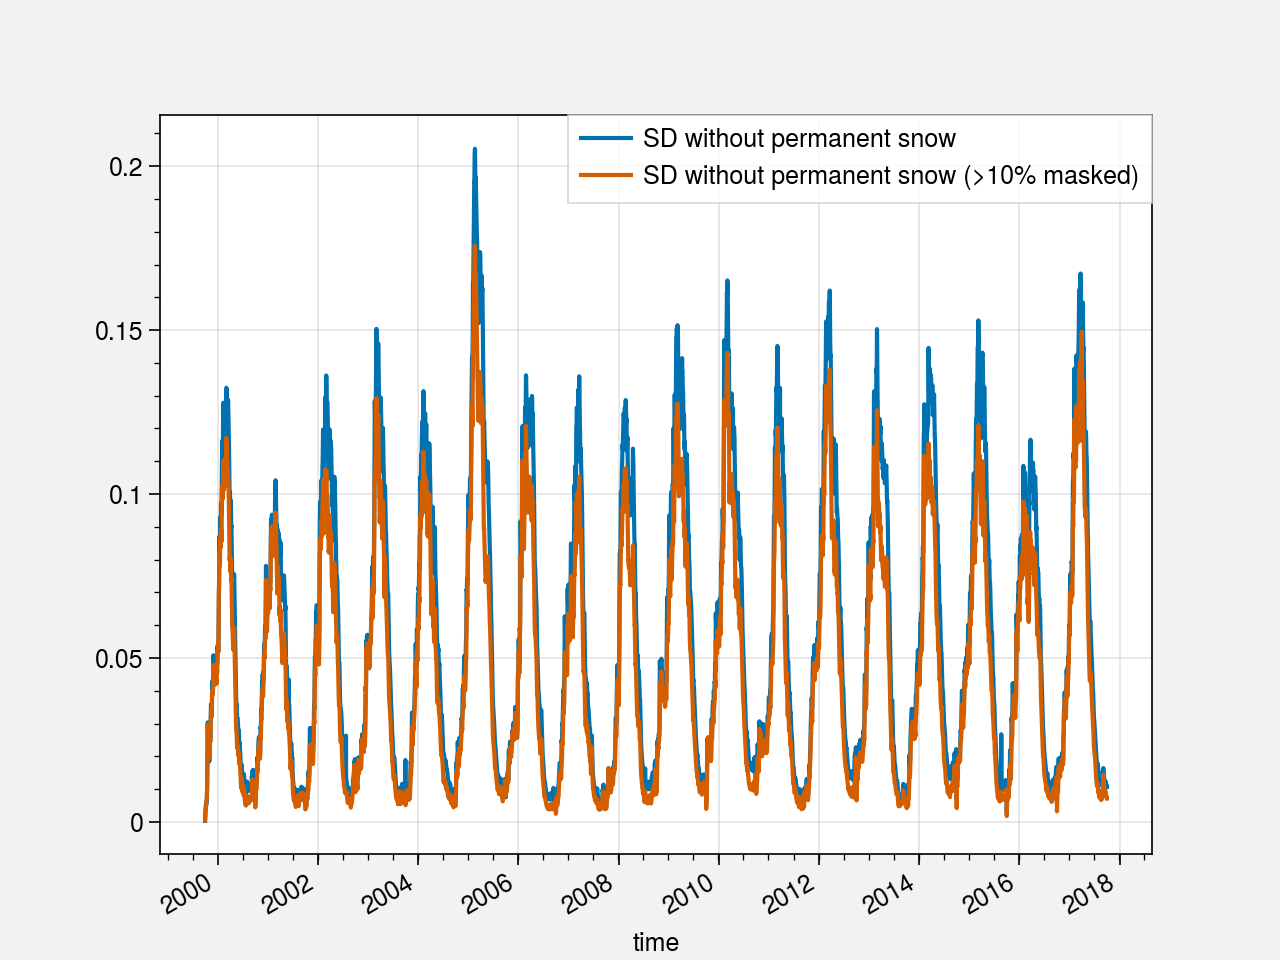

In [16]:
u.spatial_average(da).plot(label='SD without permanent snow')
u.spatial_average(da.where(mask_psnow<=30)).plot(label='SD without permanent snow (>10% masked)')
plt.legend()